In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 10
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((517, 12, 1), (517,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT10/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 14s 172ms/step - loss: 0.2576 - root_mean_squared_error: 0.5075 - val_loss: 0.2195 - val_root_mean_squared_error: 0.4686
Epoch 2/50
53/53 [==============================] - 7s 138ms/step - loss: 0.1597 - root_mean_squared_error: 0.3996 - val_loss: 0.0895 - val_root_mean_squared_error: 0.2991
Epoch 3/50
53/53 [==============================] - 7s 143ms/step - loss: 0.0754 - root_mean_squared_error: 0.2746 - val_loss: 0.0816 - val_root_mean_squared_error: 0.2857
Epoch 4/50
53/53 [==============================] - 8s 162ms/step - loss: 0.0699 - root_mean_squared_error: 0.2645 - val_loss: 0.0752 - val_root_mean_squared_error: 0.2742
Epoch 5/50
53/53 [==============================] - 8s 147ms/step - loss: 0.0662 - root_mean_squared_error: 0.2573 - val_loss: 0.0692 - val_root_mean_squared_error: 0.2631
Epoch 6/50
53/53 [==============================] - 8s 144ms/step - loss: 0.0599 - root_mean_squared_error: 0.2448 - val_loss: 0.0625 - val

53/53 [==============================] - 1s 23ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0881
Epoch 34/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941
Epoch 35/50
53/53 [==============================] - 1s 27ms/step - loss: 0.0119 - root_mean_squared_error: 0.1089 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 36/50
53/53 [==============================] - 1s 21ms/step - loss: 0.0118 - root_mean_squared_error: 0.1084 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 37/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0115 - root_mean_squared_error: 0.1071 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 38/50
53/53 [==============================] - 1s 21ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_loss: 0.0086 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.0222198446591695 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

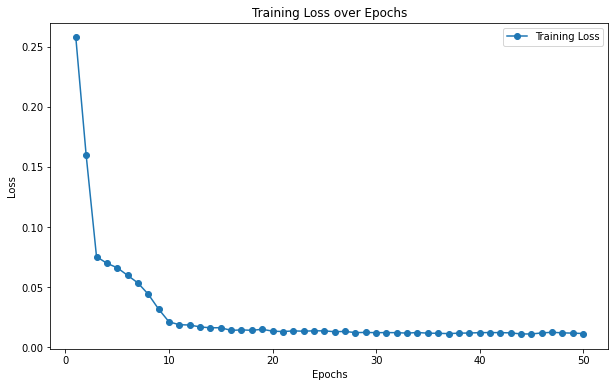

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

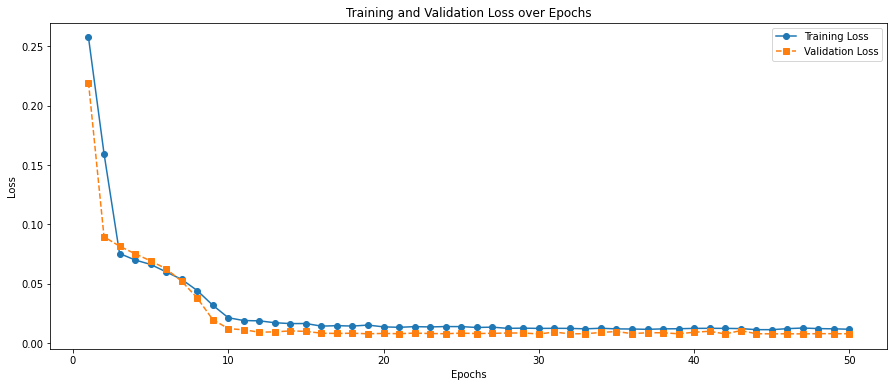

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT10/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07856443355847857
MAE : 0.0676174934749376


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,5.238834e+05,451914.219
1,5.351787e+05,439855.813
2,7.111121e+05,807857.307
3,1.022303e+06,1184280.145
4,1.469632e+06,1468308.405
5,1.860004e+06,1540851.607
6,2.152193e+06,1989099.836
7,2.234083e+06,2096990.761
8,2.105779e+06,2080961.032
9,1.795442e+06,1695704.661


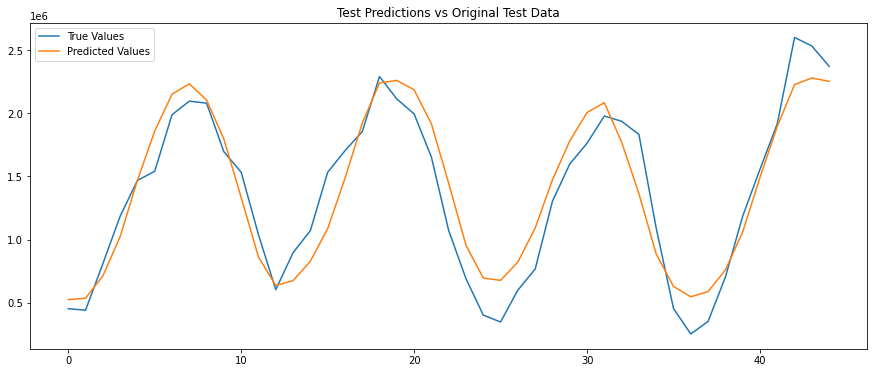

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 10ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

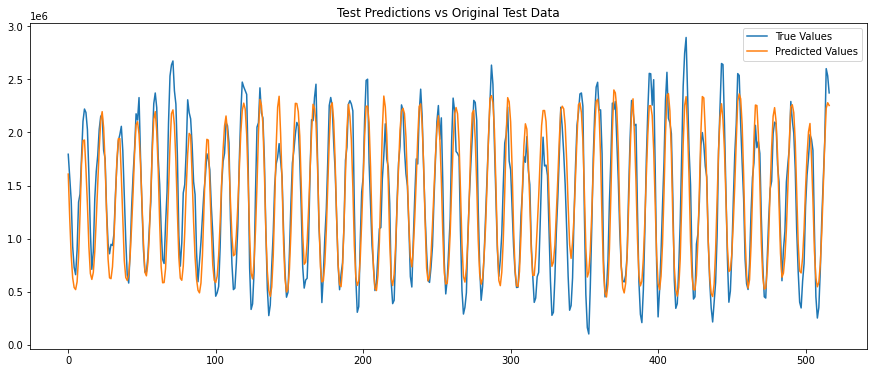

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()